In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/My Drive/Colab Notebooks/BDA/Final Project')

In [3]:
import re
import string
import numpy as np
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score

import tensorflow as tf
from tensorflow.keras import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPool2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Dense, Flatten, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv1D, Embedding, GlobalAveragePooling1D 
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.preprocessing import image

from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [4]:
df = pd.read_json("data/train.jsonl", lines=True)

In [5]:
df.shape

(8500, 4)

In [6]:
df.drop(df.columns[df.columns.str.contains('unnamed',case = False)],axis = 1, inplace = True)

In [7]:
df.shape

(8500, 4)

In [8]:
df.head()

,id,img,label,text
0,42953,img/42953.png,0,its their character not their color that matters
1,23058,img/23058.png,0,don't be afraid to love again everyone is not ...
2,13894,img/13894.png,0,putting bows on your pet
3,37408,img/37408.png,0,i love everything and everybody! except for sq...
4,82403,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [9]:
df = df.drop(columns = ['id'])

In [10]:
cleaned = df.copy()
cleaned.dropna(inplace=True)
cleaned.isnull().any()

img      False
label    False
text     False
dtype: bool

In [11]:
cleaned.shape

(8500, 3)

In [12]:
cleaned.head()

,img,label,text
0,img/42953.png,0,its their character not their color that matters
1,img/23058.png,0,don't be afraid to love again everyone is not ...
2,img/13894.png,0,putting bows on your pet
3,img/37408.png,0,i love everything and everybody! except for sq...
4,img/82403.png,0,"everybody loves chocolate chip cookies, even h..."


In [ ]:
width = 100
height = 100
X = []
for i in tqdm(range(cleaned.shape[0])):
    path = 'data/' + cleaned['img'][i]
    img = image.load_img(path,target_size=(width,height,3))
    img = image.img_to_array(img)
    img = img/255.0
    X.append(img)
        
X = np.array(X)

In [ ]:
np.save('data/images_to_array.npy', X)

In [ ]:
X.shape

(8500, 100, 100, 3)

In [13]:
X = np.load('data/images_to_array.npy')

In [14]:
X.shape

(8500, 100, 100, 3)

In [15]:
target = cleaned['label']
target = pd.get_dummies(target)
target.head()

,0,1
0,1,0
1,1,0
2,1,0
3,1,0
4,1,0


In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, target, test_size = 0.2, stratify=target)

In [17]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.experimental.preprocessing.RandomFlip('horizontal'),
  tf.keras.layers.experimental.preprocessing.RandomContrast([.5,2]),
  tf.keras.layers.experimental.preprocessing.RandomRotation(0.2),
  tf.keras.layers.experimental.preprocessing.RandomZoom(0.1)
])

preprocess_input = tf.keras.applications.resnet_v2.preprocess_input

rescale = tf.keras.layers.experimental.preprocessing.Rescaling(1./127.5, offset= -1)

In [18]:
# plt.figure(figsize=(10, 10))
# for i in range(9):
#   augmented_image = data_augmentation(X)
#   ax = plt.subplot(3, 3, i + 1)
#   plt.imshow(augmented_image[0])
#   plt.axis("off")

In [19]:
base_model_1 = tf.keras.applications.ResNet50(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')
base_model_2 = tf.keras.applications.VGG16(input_shape=X[0].shape,
                                               include_top=False,
                                               weights='imagenet')

58892288/58889256 [==============================] - 0s 0us/step


In [20]:
base_model_1.trainable = False
base_model_2.trainable = False

In [21]:
def image_model():
    image_input = tf.keras.Input(shape=(100, 100, 3), name = 'image_input')
    image_layers = data_augmentation(image_input)
    image_layers = preprocess_input(image_layers)
    layer_bm_1 = base_model_1(image_input, training=False)
    layer_bm_1 = Conv2D(2048, kernel_size=2,padding='valid')(layer_bm_1)
    layer_bm_1 = Dense(512)(layer_bm_1)
    layer_bm_2 = base_model_2(image_input, training=False)
    layer_bm_2 = Dense(512)(layer_bm_2)
    layers = tf.keras.layers.concatenate([layer_bm_1, layer_bm_2])
    image_layers = GlobalAveragePooling2D()(layers)
    image_layers = Dropout(0.2, name = 'dropout_layer')(image_layers)
    return image_input, image_layers

In [22]:
image_input, image_layers = image_model()

In [23]:
def standardization(data):
    data = data.apply(lambda x: x.lower())
    data = data.apply(lambda x: re.sub(r'\d+', '', x))
    data = data.apply(lambda x: re.sub(r'.com', '', x, flags=re.MULTILINE))
    data = data.apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
    return data

cleaned['text'] = standardization(cleaned.text)

In [24]:
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
vocab_size = 10000
sequence_length = 50

vectorize_layer = TextVectorization(
    max_tokens=vocab_size,
    output_mode='int',
    output_sequence_length=sequence_length)

text_ds = np.asarray(cleaned['text'])
vectorize_layer.adapt(tf.convert_to_tensor(text_ds))

In [25]:
X_text_train, X_text_test, y_text_train, y_text_test = train_test_split(cleaned.text, target, test_size = 0.2, stratify=target)

In [26]:
embedding_dim=16

def text_model():
    text_input = tf.keras.Input(shape=(None,), dtype=tf.string, name='text_input')
    text_layers = vectorize_layer(text_input)
    text_layers = tf.keras.layers.Embedding(vocab_size, embedding_dim, name="embedding")(text_layers)

    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)
    text_layers = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(512, activation='relu', return_sequences=True))(text_layers)
    text_layers = tf.keras.layers.BatchNormalization()(text_layers)

    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.Conv1D(128, 7, padding="valid", activation="relu", strides=3)(text_layers)
    
    text_layers = tf.keras.layers.GlobalMaxPooling1D()(text_layers)

    text_layers = tf.keras.layers.Dense(2048, activation="relu")(text_layers)
    text_layers = tf.keras.layers.Dropout(0.5)(text_layers)
    return text_input, text_layers

text_input, text_layers = text_model()

In [27]:
def model(layer_1, layer_2, image_input, text_input):
    concatenate = tf.keras.layers.concatenate([layer_1, layer_2], axis=1)
    semi_final_layer = tf.keras.layers.Dense(2048, activation='softmax')(concatenate)

    prediction_layer = tf.keras.layers.Dense(2, activation='sigmoid', name = 'meme_classification')

    output = prediction_layer(semi_final_layer)

    model = tf.keras.Model(inputs = [image_input, text_input] , 
                           outputs = output)
    return model

In [28]:
model = model(image_layers, text_layers, image_input, text_input)

In [29]:
checkpoint_dir = './training_checkpoints'

# Name of the checkpoint files
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt_{epoch}")

In [30]:
# Function for decaying the learning rate.
# You can define any decay function you need.
def decay(epoch):
  if epoch < 3:
    return 1e-1
  elif epoch >= 3 and epoch < 5:
    return 1e-2
  else:
    return 1e-5

In [31]:
# Callback for printing the LR at the end of each epoch.
class PrintLR(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    print('\nLearning rate for epoch {} is {}'.format(epoch + 1,
                                                      model.optimizer.lr.numpy()))

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_prefix,
                                       save_weights_only=True),
    tf.keras.callbacks.LearningRateScheduler(decay),
    PrintLR()
]

In [32]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
              loss = tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['binary_accuracy', 'accuracy'])

history = model.fit(x = {"image_input": X_train, "text_input": X_text_train},
                    y = y_train,
                    batch_size=256,
                    epochs=25,
                    callbacks=callbacks
                   )

Epoch 1/25
27/27 [==============================] - 82s 1s/step - loss: 0.6575 - binary_accuracy: 0.6378 - accuracy: 0.6427

Learning rate for epoch 1 is 0.10000000149011612
Epoch 2/25
27/27 [==============================] - 24s 874ms/step - loss: 0.6520 - binary_accuracy: 0.6453 - accuracy: 0.6453

Learning rate for epoch 2 is 0.10000000149011612
Epoch 3/25
27/27 [==============================] - 24s 891ms/step - loss: 0.6543 - binary_accuracy: 0.6416 - accuracy: 0.6416

Learning rate for epoch 3 is 0.10000000149011612
Epoch 4/25
27/27 [==============================] - 24s 867ms/step - loss: 0.6505 - binary_accuracy: 0.6468 - accuracy: 0.6468

Learning rate for epoch 4 is 0.009999999776482582
Epoch 5/25
27/27 [==============================] - 24s 876ms/step - loss: 0.6481 - binary_accuracy: 0.6490 - accuracy: 0.6490

Learning rate for epoch 5 is 0.009999999776482582
Epoch 6/25
27/27 [==============================] - 24s 874ms/step - loss: 0.6563 - binary_accuracy: 0.6350 - accura

In [35]:
df_history = pd.DataFrame(history.history)
df_history

,loss,binary_accuracy,accuracy,lr
0,0.654054,0.643382,0.644706,0.10000
1,0.652111,0.644853,0.644853,0.10000
2,0.655012,0.644853,0.644853,0.10000
3,0.651097,0.644853,0.644853,0.01000
4,0.650634,0.644853,0.644853,0.01000
5,0.650670,0.644853,0.644853,0.00001
6,0.650669,0.644853,0.644853,0.00001
7,0.650667,0.644853,0.644853,0.00001
8,0.650666,0.644853,0.644853,0.00001
9,0.650665,0.644853,0.644853,0.00001


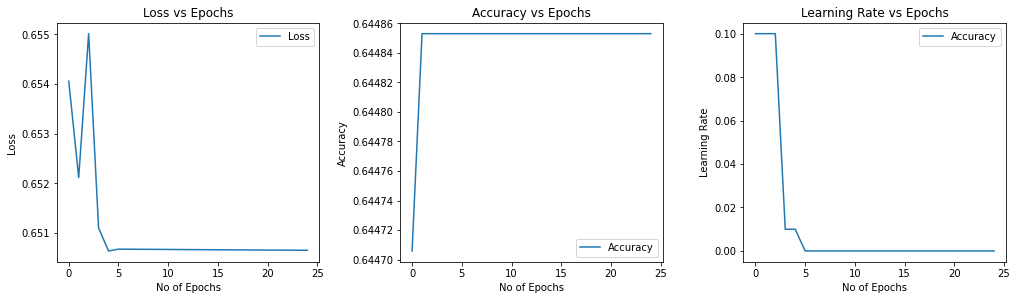

In [42]:
fig, axes = plt.subplots(1,3, figsize=(15, 5))
fig.tight_layout(pad=5.0)

axes[0].plot(df_history.loss, label = 'Loss')
axes[0].set_xlabel('No of Epochs')
axes[0].set_ylabel('Loss')
axes[0].set_title('Loss vs Epochs')
axes[0].legend()

# axes[1].plot(df_history.binary_accuracy)
# axes[1].plot(df_history.loss, label = 'Loss')
axes[1].plot(df_history.accuracy, label = 'Accuracy')
axes[1].set_xlabel('No of Epochs')
axes[1].set_ylabel('Accuracy')
axes[1].set_title('Accuracy vs Epochs')
axes[1].legend()

axes[2].plot(df_history.lr, label = 'Accuracy')
axes[2].set_xlabel('No of Epochs')
axes[2].set_ylabel('Learning Rate')
axes[2].set_title('Learning Rate vs Epochs')
axes[2].legend()
plt.show()

In [43]:
eval_ = model.evaluate(x = {"image_input": X_test, "text_input": X_text_test},
                    y = y_test,
                    batch_size=32,
                    verbose=1
                   )

54/54 [==============================] - 10s 112ms/step - loss: 0.6507 - binary_accuracy: 0.6447 - accuracy: 0.6447


In [44]:
prediction = model.predict(x = {"image_input": X_test, "text_input": X_text_test})
prediction = np.array(prediction)
prediction = np.squeeze(prediction)
prediction = 1/(1+np.exp(-np.array(prediction)))
prediction = np.where(prediction > 0.5, 1, 0)
y_true = y_test.values

micro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='micro')
macro_f1_score = f1_score(y_true[:,1], prediction[:,1], average='macro')

print("Micro F1 score for Task A is ", micro_f1_score)
print("Macro F1 score for Task A is ", macro_f1_score)

Micro F1 score for Task A is  0.3552941176470588
Macro F1 score for Task A is  0.2621527777777778


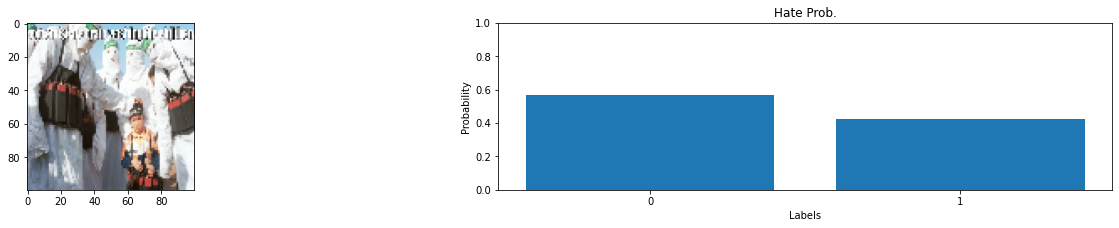

In [51]:
import random

fig, axes = plt.subplots(1,2, figsize=(20, 4))
fig.tight_layout(pad=5.0)


x = list(y_test.columns)

axes[0].imshow(X[random.randint(0,X_test.shape[0]),:,:,:])

axes[1].bar(x, model.predict(x = {"image_input": X_test, "text_input": X_text_test})[random.randint(0,X_test.shape[0]),:])
axes[1].set_xlabel('Labels')
axes[1].set_ylabel('Probability')
axes[1].set_title('Hate Prob.')
axes[1].set_xticks(x)
axes[1].set_ylim(0,1)
plt.show()

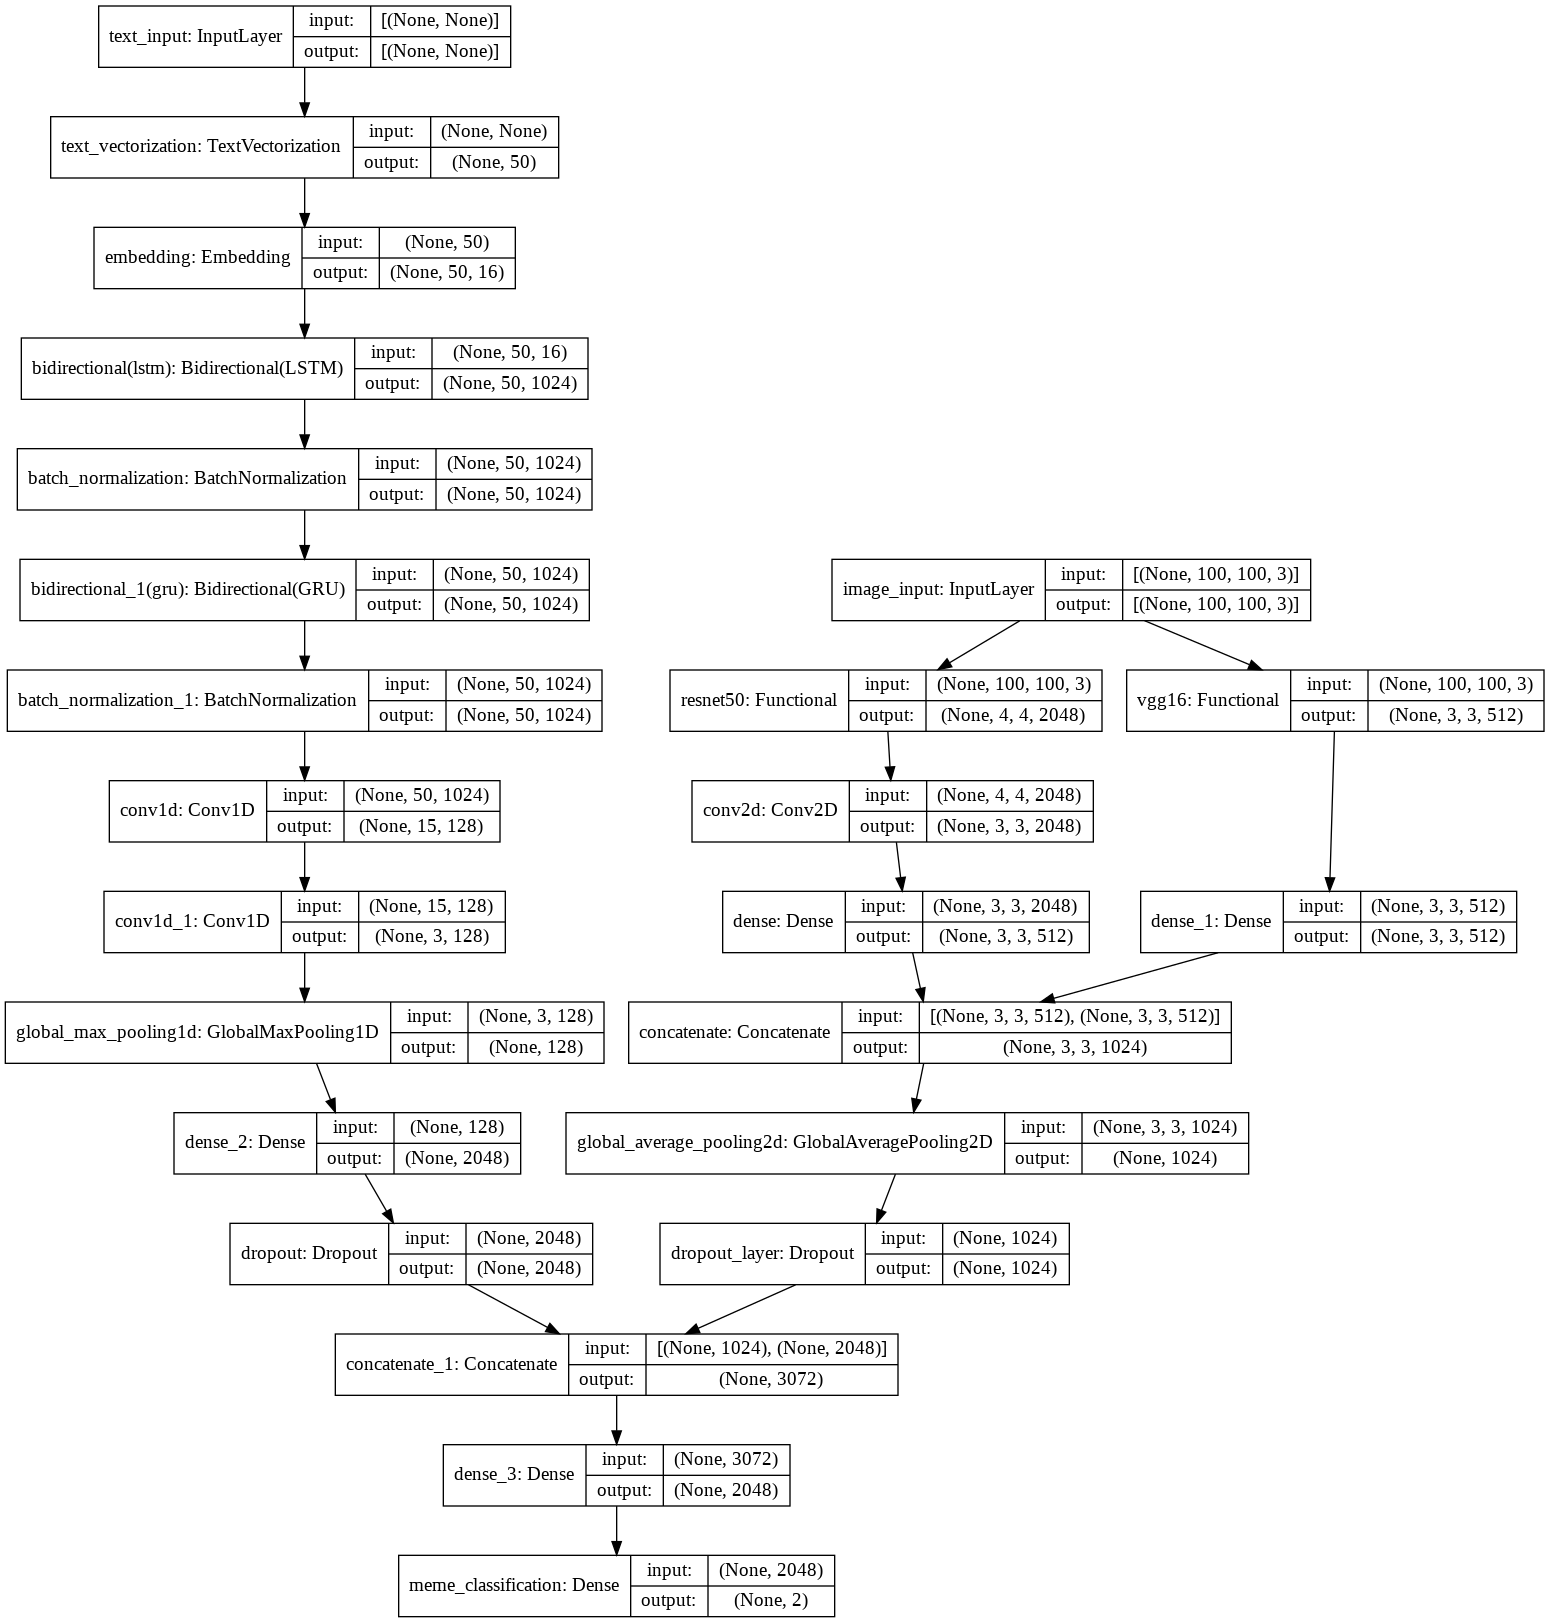

In [52]:
tf.keras.utils.plot_model(model, "multi_input_and_output_model.png", show_shapes=True)